## Preamble

In [1]:
# Useful packages
import os
import numpy as np
import scipy
from sklearn.ensemble import ExtraTreesClassifier
from utils import dataset_classification, measure_time,coloring, digits_mini, led_mini

In [2]:
# Other local importance measures
import shap
from treeinterpreter import treeinterpreter as ti

In [3]:
# Local MDI 
import LocalMDI_cy

## Model and data

In [4]:
# Choose a dataset
name = "digits"
# Make a dataset
X, y = dataset_classification(name)
# Get the size of dataset
n_samples, n_features = X.shape 
# Required change of input type
X = np.asarray(X, dtype=np.float32) 

In [5]:
# Set up the model
n_estimators = 1000
K = n_features
model = ExtraTreesClassifier(n_estimators=n_estimators, 
                             max_features=K, 
                             max_depth=None,
                             min_samples_split=2, 
                             criterion='entropy', 
                             verbose=0, n_jobs=-1)

## Training the model

In [6]:
with measure_time("Building the forest model..."):
    model.fit(X, y)

Duration of [Building the forest model...]: 0:00:01.557837


## Computing local importance scores

In [7]:
# Local MDI
with measure_time("Computing local MDI..."):
    LMDI = LocalMDI_cy.compute_mdi_local_ens(model, X)


Duration of [Computing local MDI...]: 0:00:00.179553


In [8]:
# TreeSHAP
with measure_time("Computing TreeSHAP..."):
    shap_ = shap.TreeExplainer(model).shap_values(X)
# For sake of simplicity
shap_values = np.zeros((len(np.unique(y)),n_samples, n_features))
for j in range(len(np.unique(y))):
    shap_values[j,:,:] = shap_[j]

Duration of [Computing TreeSHAP...]: 0:02:12.422528


In [9]:
# SAABAS
with measure_time("Computing Saabas..."):
    prediction, _, contributions = ti.predict(model, X)

Duration of [Computing Saabas...]: 0:00:11.557491


In [10]:
SAAB = np.zeros((n_samples, n_features))
SHAP = np.zeros((n_samples, n_features))
# TreeSHAP and Saabas values are per class
# Here, importance score is with respect to the predicted class
for j in range(n_samples):
    SAAB[j,:] = contributions[j,:,prediction[j]==1]
    SHAP[j,:] = shap_values[prediction[j]==1,j,:]

In [11]:
# Normalization & absolute value
#LMDI = np.abs(LMDI)
#SHAP = np.abs(SHAP)
#SAAB = np.abs(SAAB)
for i in range(n_samples):
    LMDI[j,:] /= np.sum(np.abs(LMDI[j,:]))
    SHAP[j,:] /= np.sum(np.abs(SHAP[j,:]))
    SAAB[j,:] /= np.sum(np.abs(SAAB[j,:]))


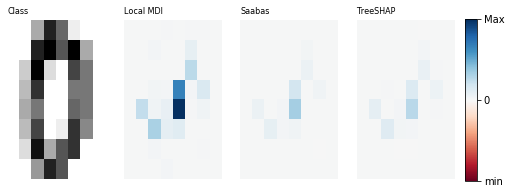

In [12]:
# As an illustration
if name == "led":
    led_mini(LMDI, SHAP, SAAB, X, 9)
elif name == "digits":
    digits_mini(LMDI, SHAP, SAAB, X, 0)